# 基于PaddleDetection的口罩检测

# 一、项目背景
防控疫情，众志成城。人工智能技术正被应用到疫情防控中来。

“控制传染源、切断传播途径和排查易感人群”是打赢抗疫的三种手段。
 
其中切断传播途径中，佩戴口罩已经几乎成为了最重要的举措之一。但是在实际场景中，仍然有不重视、不注意、侥幸心理的人员不戴口罩，尤其在公众场合，给个人和公众造成极大的风险隐患。

**在公共场合，依靠传统方法中人为监管，工作量巨大而且极为耗时**

因此，通过计算机视觉的方法，找到一种能够快速、准确检测是否佩戴口罩的算法，实现对人群是否佩戴口罩进行监控，对公共安全防控、公共资源的节省等方面具有重要的作用。

- [基于树莓派4B与Paddle-Lite实现的实时口罩识别](https://aistudio.baidu.com/aistudio/projectdetail/315730?shared=1)

- [百度飞桨携手北京地铁落地AI口罩检测方案](https://mp.weixin.qq.com/s/znrqaJmtA7CcjG0yQESWig)

- [PaddleLite C++ 口罩检测示例](https://paddle-lite.readthedocs.io/zh/latest/quick_start/cpp_demo.html?highlight=%E5%8F%A3%E7%BD%A9#id10)

为了能够便捷快速的适配各种边缘硬件设备（例如<u>xilinx FPGA</u>、<u>Inter CPU/GPU</u>），本文将训练好的<u>paddlepaddle</u>模型转化为<u>onnx</u>模型。

# 二、数据集介绍
- [数据集链接](https://aistudio.baidu.com/aistudio/datasetdetail/128634)

本项目使用的数据集照片由互联网图像库的爬虫得到，并通过使用labelimg完成标注工作，标注格式为<u>VOC</u>格式。

其中，数据集总共含有<u>1200</u>个样本

数据标签只有两个：mask和face

数据集目录格式如下：

* <u>Mask/Annotations</u>：图片标注信息，xml文件

* <u>Mask/JPEGImages</u>：图片，均为jpg格式

# 三、口罩数据集的预处理

# （1）数据集解压

In [15]:
# 查看挂载的数据集目录
!ls /home/aistudio/data

# 永久化数据解压路径和PaddleDetection安装路径
!mkdir /home/aistudio/DataSet
!mkdir /home/aistudio/PaddleDetection
!mkdir /home/aistudio/Paddle2onnx

# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
import sys 
sys.path.append('/home/aistudio/DataSet')
sys.path.append('/home/aistudio/PaddleDetection')
sys.path.append('/home/aistudio/Paddle2onnx')

In [ ]:
# 解压挂载的自定义口罩数据集到data文件夹下
!unzip -oq /home/aistudio/data/data128634/Mask.zip -d /home/aistudio/DataSet

# 查看数据集的目录结构
!tree /home/aistudio/DataSet/Mask -d

/home/aistudio/DataSet/Mask
├── Annotations
└── JPEGImages

2 directories


## （2） 数据集样本的可视化

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


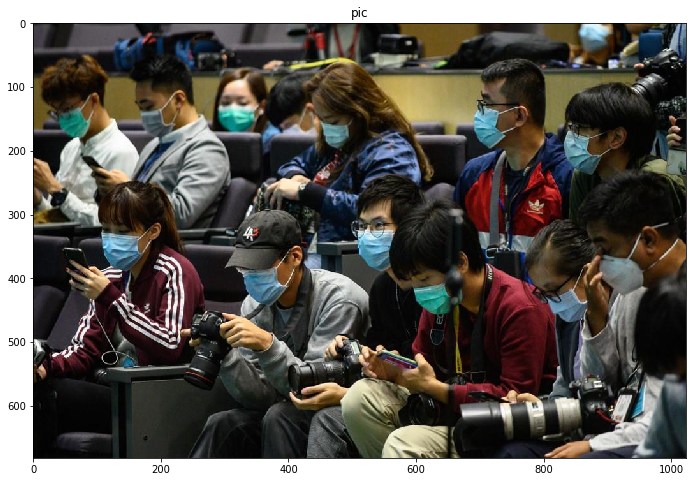

In [ ]:
# 数据集样本的可视化
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from PIL import Image

DATA_DIR = '/home/aistudio/DataSet/Mask/JPEGImages'

file = 'train_1.jpg'

# 读取图片
img = Image.open(os.path.join(DATA_DIR, file))
img = np.array(img)

# 画出读取的图片
plt.figure(figsize=(16, 8))
plt.title('pic')
plt.imshow(img)
plt.show()

## （3） 按比例划分数据集

训练数据集样本数 ： 验证数据集样本数 = <font color="red">ratio</font> : <font color="green">1 - ratio</font>

在本文，<font color="red">ratio</font>设置为0.8

In [ ]:
import random
import os
#生成train.txt和val.txt
random.seed(2020)
xml_dir  = '/home/aistudio/DataSet/Mask/Annotations'#标签文件地址
img_dir = '/home/aistudio/DataSet/Mask/JPEGImages'#图像文件地址
path_list = list()
for img in os.listdir(img_dir):
    img_path = os.path.join(img_dir,img)
    xml_path = os.path.join(xml_dir,img.replace('jpg', 'xml'))
    path_list.append((img_path, xml_path))
random.shuffle(path_list)
ratio = 0.8
train_f = open('/home/aistudio/work/train.txt','w') #生成训练文件
val_f = open('/home/aistudio/work/val.txt' ,'w')#生成验证文件

for i ,content in enumerate(path_list):
    img, xml = content
    text = img + ' ' + xml + '\n'
    if i < len(path_list) * ratio:
        train_f.write(text)
    else:
        val_f.write(text)
train_f.close()
val_f.close()

#生成标签文档
label = ['mask','face']#设置你想检测的类别
with open('/home/aistudio/work/label_list.txt', 'w') as f:
    for text in label:
        f.write(text+'\n')

## （4）将VOC数据集转化为COCO数据集（可选）

如果在模型训练时使用**COCO**数据集的话，在这里需要执行该脚本。

在执行数据转化脚本之前需要先安装 `PaddleDetection` 工具

在本文，我使用的是**VOC**数据集进行模型训练，故不再转换数据集标注格式

In [ ]:
#!python /home/aistudio/PaddleDetection/tools/x2coco.py \
#        --dataset_type voc \
#        --voc_anno_dir /home/aistudio/DataSet/Mask/Annotations/ \
#        --voc_anno_list /home/aistudio/work/train.txt \
#        --voc_label_list /home/aistudio/work/label_list.txt \
#        --voc_out_name /home/aistudio/work/voc_train.json

#!python /home/aistudio/PaddleDetection/tools/x2coco.py \
#        --dataset_type voc \
#        --voc_anno_dir /home/aistudio/DataSet/Mask/Annotations/ \
#        --voc_anno_list /home/aistudio/work/val.txt \
#        --voc_label_list /home/aistudio/work/label_list.txt \
#        --voc_out_name /home/aistudio/work/voc_val.json

# 四、PaddleDetection安装与环境配置

In [ ]:
# 克隆paddledetection仓库
!git clone https://gitee.com/PaddlePaddle/PaddleDetection.git -b release/2.3

Cloning into 'PaddleDetection'...
remote: Enumerating objects: 21396, done.
remote: Counting objects: 100% (1866/1866), done.
remote: Compressing objects: 100% (934/934), done.
remote: Total 21396 (delta 1313), reused 1301 (delta 929), pack-reused 19530
Receiving objects: 100% (21396/21396), 202.22 MiB | 17.38 MiB/s, done.
Resolving deltas: 100% (15862/15862), done.
Checking connectivity... done.


In [ ]:
# 安装所需依赖项
# 已经配置过一次便不需要执行下面一行的配置代码
!pip install -r /home/aistudio/PaddleDetection/requirements.txt

In [ ]:
%cd /home/aistudio/PaddleDetection/
!pip install paddledet

In [ ]:
# 测试一下环境是否成功搭建
%cd /home/aistudio/PaddleDetection/
!python ppdet/modeling/tests/test_architectures.py

/home/aistudio/PaddleDetection
W0224 18:10:35.777540   464 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0224 18:10:35.782413   464 device_context.cc:465] device: 0, cuDNN Version: 7.6.
.......
----------------------------------------------------------------------
Ran 7 tests in 3.654s

OK


OK!至此，我们已经完成了<u>数据集的预处理</u>和<u>环境的搭建</u>工作。

下面将进入到最为重要的一环：**模型训练**

# 五、模型选择并训练

## （1） 模型选择与介绍
由于在未来有计划将该口罩检测任务部署到边缘端，再考虑到模型精度问题，我选择使用**PaddleDetection**下的**PP-YOLOv2**模型完成模型训练的工作。

**PP-YOLOv2 模型简介**

相较20年发布的PP-YOLO，v2版本在COCO 2017 test-dev上的精度提升了3.6个百分点，由45.9%提升到了49.5%；在640*640的输入尺寸下，FPS达到68.9FPS。 PP-YOLOv2在同等速度下，精度超越YOLOv5！

<div align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/3f0ca399f712482a9ebb1c32ebe6945d69bb610e3aa849a89a4f80910c5c763c" width=500 />
</div>


**PP-YOLO模型库**

|          Model           | GPU number | images/GPU |  backbone  | input shape | Box AP<sup>val</sup> | Box AP<sup>test</sup> | V100 FP32(FPS) | V100 TensorRT FP16(FPS) | download | config  |
|:------------------------:|:-------:|:-------------:|:----------:| :-------:| :------------------: | :-------------------: | :------------: | :---------------------: | :------: | :------: |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     608     |         44.8         |         45.2          |      72.9      |          155.6          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     512     |         43.9         |         44.4          |      89.9      |          188.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     416     |         42.1         |         42.5          |      109.1      |          215.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO                  |     8      |     24     | ResNet50vd |     320     |         38.9         |         39.3          |      132.2      |          242.2          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     608     |         45.3         |         45.9          |      72.9      |          155.6          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     512     |         44.4         |         45.0          |      89.9      |          188.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     416     |         42.7         |         43.2          |      109.1      |          215.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO_2x               |     8      |     24     | ResNet50vd |     320     |         39.5         |         40.1          |      132.2      |          242.2          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_2x_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r50vd_dcn_2x_coco.yml)                   |
| PP-YOLO               |     4      |     32     | ResNet18vd |     512     |         29.2         |         29.5          |      357.1      |          657.9          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r18vd_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r18vd_coco.yml)                   |
| PP-YOLO               |     4      |     32     | ResNet18vd |     416     |         28.6         |         28.9          |      409.8      |          719.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r18vd_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r18vd_coco.yml)                   |
| PP-YOLO               |     4      |     32     | ResNet18vd |     320     |         26.2         |         26.4          |      480.7      |          763.4          | [model](https://paddledet.bj.bcebos.com/models/ppyolo_r18vd_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolo_r18vd_coco.yml)                   |
| PP-YOLOv2               |     8      |     12     | ResNet50vd |     640     |         49.1         |         49.5          |      68.9      |          106.5          | [model](https://paddledet.bj.bcebos.com/models/ppyolov2_r50vd_dcn_365e_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolov2_r50vd_dcn_365e_coco.yml)                   |
| PP-YOLOv2               |     8      |     12     | ResNet101vd |     640     |         49.7         |         50.3          |     49.5     |         87.0         | [model](https://paddledet.bj.bcebos.com/models/ppyolov2_r101vd_dcn_365e_coco.pdparams) | [config](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.0/configs/ppyolo/ppyolov2_r101vd_dcn_365e_coco.yml)                   |


**注意:**

- PP-YOLO模型使用COCO数据集中train2017作为训练集，使用val2017和test-dev2017作为测试集，Box AP<sup>test</sup>为`mAP(IoU=0.5:0.95)`评估结果。
- PP-YOLO模型训练过程中使用8 GPUs，每GPU batch size为24进行训练，如训练GPU数和batch size不使用上述配置，须参考[FAQ](https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.0/static/docs/FAQ.md)调整学习率和迭代次数。
- PP-YOLO模型推理速度测试采用单卡V100，batch size=1进行测试，使用CUDA 10.2, CUDNN 7.5.1，TensorRT推理速度测试使用TensorRT 5.1.2.2。
- PP-YOLO模型FP32的推理速度测试数据为使用`tools/export_model.py`脚本导出模型后，使用`deploy/python/infer.py`脚本中的`--run_benchnark`参数使用Paddle预测库进行推理速度benchmark测试结果, 且测试的均为不包含数据预处理和模型输出后处理(NMS)的数据(与[YOLOv4(AlexyAB)](https://github.com/AlexeyAB/darknet)测试方法一致)。
- TensorRT FP16的速度测试相比于FP32去除了`yolo_box`(bbox解码)部分耗时，即不包含数据预处理，bbox解码和NMS(与[YOLOv4(AlexyAB)](https://github.com/AlexeyAB/darknet)测试方法一致)。

## （2） 修改配置文件
这里使用的配置文件是 `/home/aistudio/PaddleDetection/configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml` 文件

下面介绍一下配置文件里面的参数表达的意思

 `../datasets/voc.yml`主要说明了训练数据和验证数据的路径

 `../runtime.yml`主要说明了公共的运行参数，比如说是否使用GPU、每多少个epoch存储checkpoint等

 `./_base_/ppyolov2_r50vd_dcn.yml` 主要说明模型、和主干网络的情况。

 `./_base_/optimizer_365e.yml`主要说明了学习率和优化器的配置。

 `./_base_/ppyolov2_reader.yml`主要说明数据读取器配置，如batch size，并发加载子进程数等，同时包含读取后预处理操作，如resize、数据增强等等

**修改部分：**

需要修改数据集的路径，即对应的红色部分

`PaddleDetection/configs/datasets/voc.yml`


![](https://ai-studio-static-online.cdn.bcebos.com/b8071d5be95b4cbdac50d9be69182ce6352e2098580a4f138970c6c008468e50)


然后进入 `PaddleDetection/configs/ppyolo/_base_/optimizer_365e.yml` ,修改**epoch**改为300次,修改**学习率lr**为0.0025

![](https://ai-studio-static-online.cdn.bcebos.com/42cc7c65537b4b358595700a376faaff986df883bba74174b38288e6e1afcb88)


还需要进入 `/home/aistudio/PaddleDetection/configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml` ，修改epoch、snapshot

![](https://ai-studio-static-online.cdn.bcebos.com/814466887cb44f009e0020151c46960ae0d11afca31e431b9a5e330a8e94ebf2)



如果爆内存就修改这个文件的batch_size：

`PaddleDetection/configs/ppyolo/_base_/ppyolov2_reader.yml`


在这里我将batchsize改为4


![](https://ai-studio-static-online.cdn.bcebos.com/b5e7e2696aa74a7eb433b28a3dabc10af923d19ead1647ab8b982ba12835fb5e)

## （3）模型训练

使用GPU通过如下命令一键式启动训练(以下命令均默认在PaddleDetection根目录运行), 通过`--eval`参数开启训练中交替评估。

```bash
CUDA_VISIBLE_DEVICES=0 python tools/train.py -c configs/ppyolo/ppyolo.yml --eval
```
可选：在训练之前使用`tools/anchor_cluster.py`得到适用于你的数据集的anchor，并修改`configs/ppyolo/ppyolo.yml`中的anchor设置
```bash
python tools/anchor_cluster.py -c configs/ppyolo/ppyolo.yml -n 9 -s 608 -m v2 -i 1000
```

In [ ]:
# 开始训练
%cd /home/aistudio/PaddleDetection/
!CUDA_VISIBLE_DEVICES=0
!python tools/train.py \
    -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml \
    --resume output/ppyolov2_r50vd_dcn_voc/89.pdparams \
    --eval

## （4）模型保存

模型训练结果保存在 `/home/aistudio/PaddleDetection/output/ppyolov2_r50vd_dcn_voc` 目录下

下面将效果最好的模型参数另存到 `/home/aistudio/work` 目录下

In [ ]:
!cp /home/aistudio/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdopt /home/aistudio/work
!cp /home/aistudio/PaddleDetection/output/ppyolov2_r50vd_dcn_voc/best_model.pdparams /home/aistudio/work

# 六、模型预测

## （1）模型评估

In [ ]:
%cd /home/aistudio/PaddleDetection/
!python -u tools/eval.py -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml -o weights=/home/aistudio/work/best_model.pdparams

/home/aistudio/PaddleDetection
W0224 17:15:36.664734  8835 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0224 17:15:36.670354  8835 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/24 17:15:41] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/best_model.pdparams
[02/24 17:15:41] ppdet.engine INFO: Eval iter: 0
[02/24 17:15:45] ppdet.engine INFO: Eval iter: 100
[02/24 17:15:50] ppdet.engine INFO: Eval iter: 200
[02/24 17:15:52] ppdet.metrics.metrics INFO: Accumulating evaluatation results...
[02/24 17:15:52] ppdet.metrics.metrics INFO: mAP(0.50, 11point) = 84.34%
[02/24 17:15:52] ppdet.engine INFO: Total sample number: 240, averge FPS: 21.633217941323505


**从模型评估结果可以看得出，mAP可达到80+，模型精度尚可**

![](https://ai-studio-static-online.cdn.bcebos.com/8e5650661a05483281bf420029d325a7cd836aedad264d74a953cb6b71945617)


## （2）模型预测

In [ ]:
# 将待预测图片输入到模型
%cd /home/aistudio/PaddleDetection/
!python tools/infer.py \
        -c configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml \
        -o weights=/home/aistudio/work/best_model.pdparams \
        --infer_img=/home/aistudio/test.jpg

/home/aistudio/PaddleDetection
W0224 17:19:41.804229  9267 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0224 17:19:41.809790  9267 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/24 17:19:45] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/best_model.pdparams
[02/24 17:19:46] ppdet.engine INFO: Detection bbox results save in output/test.jpg


**模型推理结果保存在 `PaddleDetection/output` 路径下**

In [ ]:
#将输出结果拷贝到/home/aistudio/work目录下
!cp /home/aistudio/PaddleDetection/output/test.jpg /home/aistudio/work

## （3）可视化模型预测效果

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


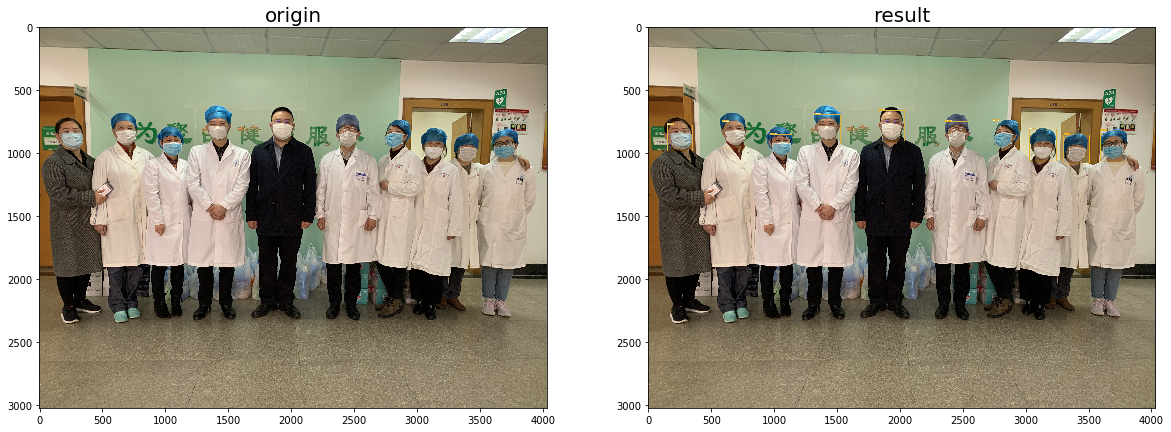

In [ ]:
# 同时展示原图像和模型预测的结果
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from PIL import Image

# 读取图片
original = Image.open('/home/aistudio/test.jpg')
original = np.array(original)
result = Image.open('/home/aistudio/work/test.jpg')
result = np.array(result)

# 画出读取的图片
plt.figure(figsize=(20, 10))
f = plt.subplot(121)
f.set_title('origin', fontsize=20)
plt.imshow(original)
f = plt.subplot(122)
f.set_title('result', fontsize=20)
plt.imshow(result)
plt.show()

**可以清晰的看见图片中所有戴口罩的人脸全被预测出来**


![](https://ai-studio-static-online.cdn.bcebos.com/ed614893e74446c3809db651578edf35c678e3c751e64d3d87e8b81269be019d)



# 七、导出模型

In [ ]:
# 导出模型
!cd /home/aistudio/PaddleDetection/
!python tools/export_model.py \
        -c /home/aistudio/PaddleDetection/configs/ppyolo/ppyolov2_r50vd_dcn_voc.yml \
        -o weights=/home/aistudio/work/best_model.pdparams \
        --output_dir /home/aistudio/output

[02/24 17:21:58] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/best_model.pdparams
[02/24 17:21:58] ppdet.engine INFO: Export inference config file to /home/aistudio/output/ppyolov2_r50vd_dcn_voc/infer_cfg.yml
W0224 17:22:04.055876  9470 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0224 17:22:04.055944  9470 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/24 17:22:09] ppdet.engine INFO: Export model and saved in /home/aistudio/output/ppyolov2_r50vd_dcn_voc


## Netron -- 模型结构可视化

In [ ]:
# 安装netron
!pip install netron

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 1.4 MB 3.5 MB/s            
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [ ]:
# 通过netron查看网络结构
!netron /home/aistudio/output/ppyolov2_r50vd_dcn_voc/model.pdmodel

Serving '/home/aistudio/output/ppyolov2_r50vd_dcn_voc/model.pdmodel' at http://localhost:8080
^C

Stopping http://localhost:8080


**由于模型复杂，下图只展示模型顶部head层的结构：**

![](https://ai-studio-static-online.cdn.bcebos.com/4544644cabb240f6918ba505828b46e4afd9edbd68b9430082c1c84ae5776795)


# 八、将paddle模型转化为onnx

## （1）onnx介绍

ONNX (Open Neural Network Exchange) 是针对机器学习所设计的开源文件格式，用于存储训练好的模型。它使得不同的人工智能框架可以采用相同格式存储模型并交互。通过ONNX格式，Paddle模型可以使用OpenVINO、ONNX Runtime等框架进行推理。假设一个模型通过学习框架训练好后，我们可以把它存储下来，然后存储的格式可以使用ONNX的这种格式，在模型中模型构造是有向无环的，图里面它有很多的节点，然后每一个节点会有一个或者多个的输入，并且这个节也会有一个或者多个的输出。这些输入和输出就可以构成一副完整的图。每个节点都是都成为一个OP。

![](https://docs.microsoft.com/zh-cn/azure/machine-learning/media/concept-onnx/onnx.png#lightbox)

有了ONNX模型后，不同的算法架构的模型也可以使用相同的这种文件格式进行存储。

实际中可能遇到这样子一个问题，如果你遇到很好的一个pytorch模型，但是你无法获取他们的数据集，或者没有硬件条件去支撑设备。在这个时候科学那我们就有一个很好的想法，就是说把pytorch这个模型呢，直接迁移过来，然后进行部署就可以解决这个问题。在这里，就提供一种新的解决方案，就是我们可以通过ONNX接受的转换格式。首先，我们将想要转换的pytorch模型保存出来，保存成一个ONNX格式，保存之后呢，因为我们是ONNX格式，它可以通过，比如说我们的操作paddleX（paddle的一个工具套件）进行转换。然后就可以转换成我们的一个paddle的一个inference模型。之后就可以通过这个inference模型去进行部署了。

## （2）paddle2onnx简介
飞桨是国内最早开源的框架，早就已经和ONNX进行了深入的合作，也开源了paddle2ONNX作为paddle paddle的一个核心模块，然后支持将paddlepaddle框架训练的这个模型直接保存为ONNX格式来帮助我们的开发者快速地将我们的paddle模型高速、高效、灵活地部署到各种主流的平台上。

简而言之，**ONNX是直接使用paddle模型到到各种平台上的一个桥梁。**

## （3）环境准备
安装依赖 这里首先要安装的是pycocotools、paddle2onnx、onnxruntime，第三个是我们到时候部署验证的时候会使用到onnxruntime，第一个是pycocotools（python api tools of COCO）用来处理COCO的数据集。一定要制定onnx的版本，他需要小于1.9.0。

In [ ]:
!pip install pycocotools paddle2onnx onnxruntime

In [ ]:
!pip install onnx==1.9.0

In [16]:
# 克隆paddle2onnx
!git clone https://github.com/PaddlePaddle/paddle2onnx.git /home/aistudio/Paddle2onnx/

Cloning into '/home/aistudio/Paddle2onnx'...
remote: Enumerating objects: 5302, done.
remote: Counting objects: 100% (2333/2333), done.
remote: Compressing objects: 100% (814/814), done.
remote: Total 5302 (delta 1988), reused 1675 (delta 1516), pack-reused 2969
Receiving objects: 100% (5302/5302), 2.34 MiB | 0 bytes/s, done.
Resolving deltas: 100% (3513/3513), done.
Checking connectivity... done.


In [17]:
# 安装paddle2onnx
!python /home/aistudio/Paddle2onnx/setup.py install

## （4）将模型转化为onnx

![](https://ai-studio-static-online.cdn.bcebos.com/30da041155694be9a8b45b624282f8f9f79e7e996c174e7f93932955135ab5c6)

In [18]:
!paddle2onnx \
        --model_dir /home/aistudio/output/ppyolov2_r50vd_dcn_voc \
        --model_filename model.pdmodel \
        --params_filename model.pdiparams \
        --save_file /home/aistudio/ppyolov2_voc.onnx \
        --opset_version 12 \
        --enable_onnx_checker True

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/framework.py:2253: UserWarning: The Attr(force_cpu) of Op(fill_constant) will be deprecated in the future, please use 'device_guard' instead. 'device_guard' has higher priority when they are used at the same time.
  "used at the same time." % type)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:341: UserWarning: /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle2onnx/op_mapper/custom_paddle_op/deformable_conv.py:212
The behavior of expression A - B has been unified with elementwise_sub(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_sub(X, Y, axis=0) instead of A - B. This transitional warning will be dropped in the future.
  op_type, op_type, EXPRESSION_MAP[method_name]))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fl

**可以看到，模型成功转化为onnx格式**

![](https://ai-studio-static-online.cdn.bcebos.com/5ea4fb5230ef414886a10b72b177b5ef336bd24db33949fdbdfaec1d7c4e0f0e)


## （5）onnx模型测试

In [19]:
import os
import onnxruntime

def load_onnx(model_dir):
    model_path = os.path.join(model_dir, 'ppyolov2_voc.onnx')
    session = onnxruntime.InferenceSession(model_path)

    input_names = [input.name for input in session.get_inputs()]
    output_names = [output.name for output in session.get_outputs()]

    return session, input_names, output_names

session, input_names, output_names = load_onnx("/home/aistudio")

print(input_names, output_names)

['im_shape', 'image', 'scale_factor'] ['matrix_nms_0.tmp_0', 'matrix_nms_0.tmp_2']


2022-02-24 18:23:04.017113905 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'Constant_1188'. It is not used by any node and should be removed from the model.


# 九、总结

到此我们可以看到，使用PP-YOLOV2完成了是否佩戴口罩的目标识别检测，并且mAP已经达到了84.34%。

而且模型已经转化为onnx，便于部署到不同的硬件平台上

**优化方案：**

> 可以通过增加数据集、选择更优化模型，增加训练的次数。

**后期应用：**

> 后期可以部署到商场、医院、疗养院等公共场合的进出口，配合工作人员进行安全管控。

# 作者简介

> - [个人主页](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/1966674)

> - 感兴趣的方向：CV

> - 欢迎大家有问题留言交流学习，共同进步成长。

